# Understanding our dataset:

- First we load the df from the csv file and clean it using the functions inside utils/utils.py

In [1]:
import utils.utils as u
import utils.stats as s
import seaborn as sns
import pandas as pd
df = u.clean_df("data.csv")
display(df.dtypes)

URL                              object
Type                             object
Subtype                          object
Price                           float64
Bedroom                         float64
Living_area                     float64
Listing_address                  object
Postal_code                     float64
Locality                         object
District                         object
Swimming_pool                      bool
Garden                             bool
Garden_area                     float64
Surface_of_land                 float64
Terrace                            bool
Kitchen                          object
Facade                          float64
Open Fire                          bool
Furnished                          bool
State of the building            object
zip                      string[python]
city                             object
lng                             float64
lat                             float64
Province                         object


- Let's see our Dataset size

In [2]:
display(df.shape)

(9716, 25)

Do we have Nulls and NaNs?

In [3]:
display(df.isnull().sum())

URL                         0
Type                        0
Subtype                     0
Price                       0
Bedroom                     0
Living_area               843
Listing_address             0
Postal_code                 0
Locality                    0
District                    0
Swimming_pool               0
Garden                      0
Garden_area              7808
Surface_of_land          3656
Terrace                     0
Kitchen                     0
Facade                   2598
Open Fire                   0
Furnished                   0
State of the building       0
zip                         0
city                        0
lng                         0
lat                         0
Province                    0
dtype: int64

Let's look at the outliers of our data (more than 3 std away from average).

Price          154
Bedroom         65
Living_area     99
dtype: int64

[Text(0.5, 1.0, 'Outliers'),
 Text(0, 0.5, 'Density'),
 Text(0.5, 0, 'STD away from average')]

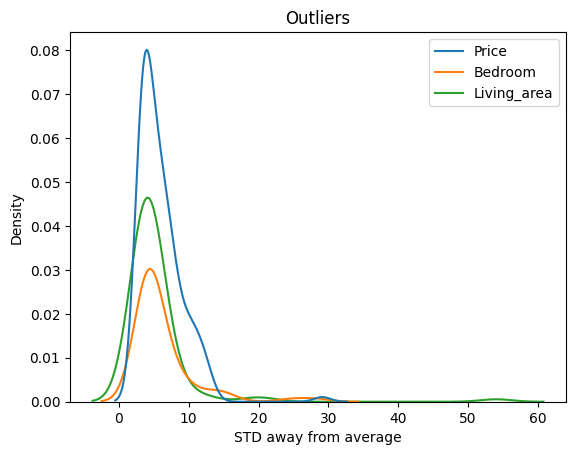

In [30]:
std = df.select_dtypes('float').std()
distance = abs(df.select_dtypes('float')-df.select_dtypes('float').mean()).div(std)
price_outliers = distance.loc[distance["Price"] > 3, "Price"]
bedroom_outliers = distance.loc[distance["Bedroom"] > 3, "Bedroom"]
living_outliers = distance.loc[distance["Living_area"] > 3, "Living_area"]
outliers=pd.concat([price_outliers, bedroom_outliers,living_outliers], axis=1)
display(outliers.count())
plot = sns.kdeplot(outliers)
plot.set(title="Outliers", ylabel="Density", xlabel="STD away from average")

Let's see the distribution of living area in our sample

<Axes: xlabel='Living_area', ylabel='Count'>

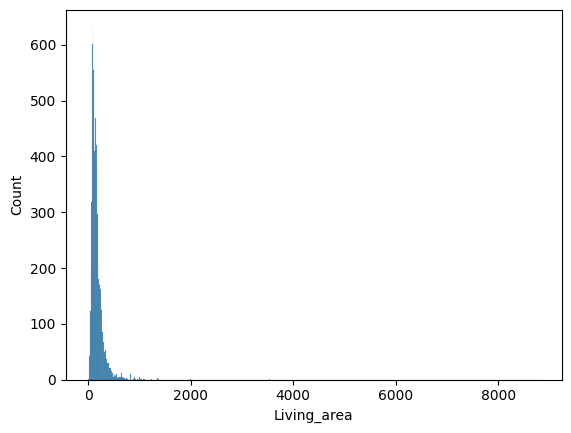

In [9]:
sns.histplot(data=df, x="Living_area")

Oppsie, we forgot to remove the outliers

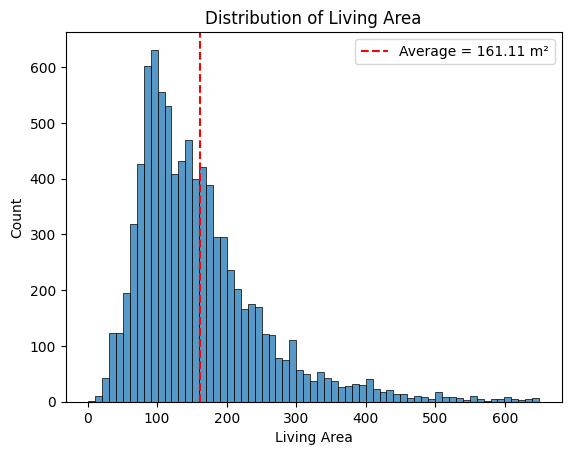

In [56]:
df_clean_outliers= df[~df.index.isin(living_outliers.index)]
plot = sns.histplot(data=df_clean_outliers, x="Living_area")

plot.set(title="Distribution of Living Area", xlabel="Living Area")
avg=df_clean_outliers["Living_area"].mean()
plot.axvline(x=avg, c='red', ls="--", label=("Average = " + str(round(avg,2)) + " m²"))
l, h = plot.get_legend_handles_labels()
plot.legend(loc="upper right")


Let's see how the price is by Province

[Text(0.5, 1.0, 'Average listing price per Province')]

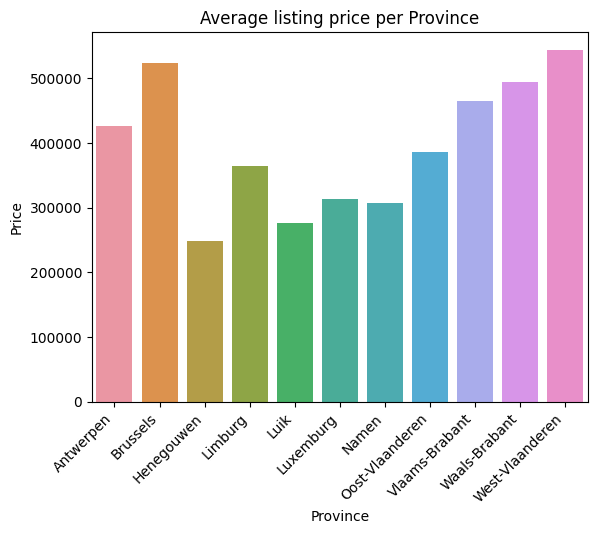

In [11]:
plot = sns.barplot(data=df_clean_outliers.loc[:,["Price", "Province"]].groupby("Province", as_index=False).mean(), x="Province", y="Price")
plot.set_xticklabels(plot.get_xticklabels(),rotation=45, horizontalalignment='right')
plot.set(title="Average listing price per Province")

/tmp/ipykernel_49747/3248696172.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_outliers["Square_meter"]= df_clean_outliers["Price"]/df_clean_outliers["Living_area"]


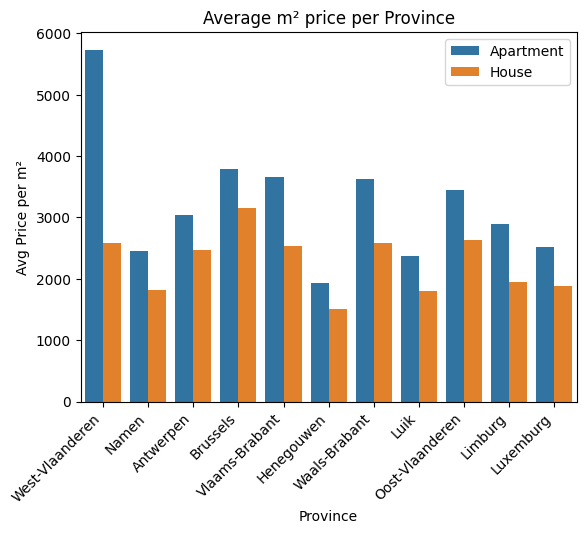

In [16]:
df_clean_outliers["Square_meter"]= df_clean_outliers["Price"]/df_clean_outliers["Living_area"]
plot = sns.barplot(data=df_clean_outliers, x="Province", y="Square_meter", hue="Type", errorbar=None)
plot.set(ylabel="Avg Price per m²", title="Average m² price per Province")
plot.set_xticklabels(plot.get_xticklabels(),rotation=45, horizontalalignment='right')
plot.legend(labels=["Apartment", "House"])

I guess if you want to live in West-Vlaanderen, do it in a house!

Let's take a look at those prices in a simulated map

[Text(0.5, 1.0, 'Map of m² price in Belgium'),
 Text(0.5, 0, 'Longitude'),
 Text(0, 0.5, 'Latitude')]

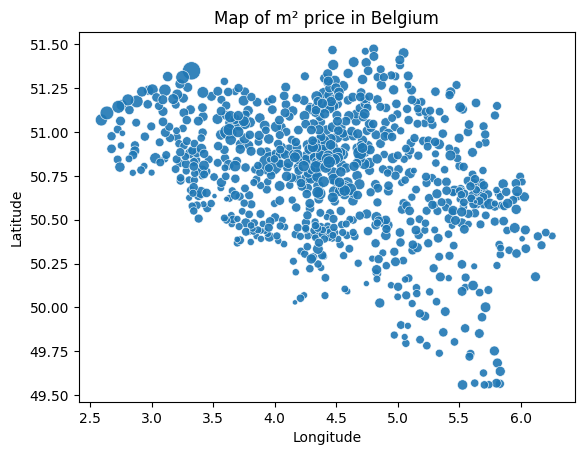

In [42]:
plot = sns.scatterplot(data=df_clean_outliers[["Square_meter","lat", "lng","city"]].groupby("city").mean(), x="lng", y="lat", size="Square_meter", sizes=(10,300), alpha=0.9, legend=False)
plot.set(title="Map of m² price in Belgium",xlabel="Longitude", ylabel="Latitude")

Seems like West-Vlaanderen is expensive because everyone wants an apartment on the beach. Seems reasonable!

Let's see the cheapest town in belgium!

In [18]:
cities = df_clean_outliers.loc[:, ["city", "Price", "Square_meter"]].groupby("city").agg(["mean"])
cities.loc[cities.idxmin(), :]

,Price,Square_meter
,mean,mean
city,,
Vaux-Sous-Chèvremont,9500.0,83.333333
Vaux-Sous-Chèvremont,9500.0,83.333333


What about the most expensive?

In [19]:
cities = df_clean_outliers.loc[:, ["city", "Price", "Square_meter"]].groupby("city").agg(["mean"])
cities.loc[cities.idxmax(), :]

,Price,Square_meter
,mean,mean
city,,
Sint-Martens-Latem,2300000.0,4356.060606
Appelterre-Eichem,382250.0,17832.745312


- Correlation between our variables and the price

,Bedroom,Living_area,Garden_area,Surface_of_land,Facade,Price
Bedroom,1.000000,0.698308,0.203234,0.054655,0.180043,0.335601
Living_area,0.698308,1.000000,0.262350,0.121001,0.268135,0.484650
Garden_area,0.203234,0.262350,1.000000,0.954536,0.279633,0.167660
Surface_of_land,0.054655,0.121001,0.954536,1.000000,0.165338,0.135472
Facade,0.180043,0.268135,0.279633,0.165338,1.000000,0.154375
Price,0.335601,0.484650,0.167660,0.135472,0.154375,1.000000


[Text(0.5, 1.0, 'Correlation between Price and numeric variables')]

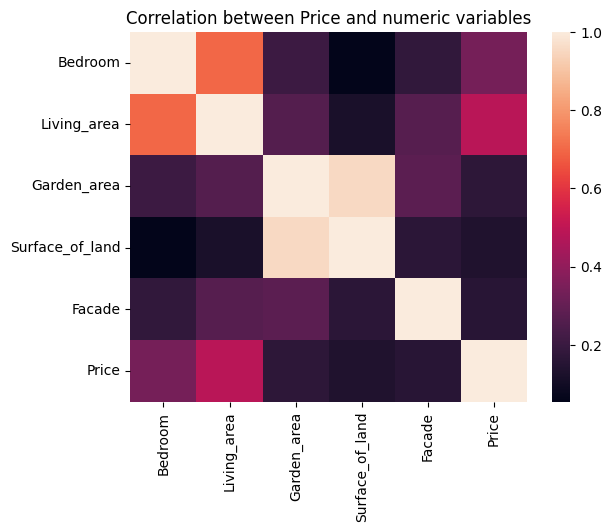

In [44]:
numeric_corr = df_clean_outliers[["Bedroom", "Living_area", "Garden_area", "Surface_of_land", "Facade", "Price"]].corr()
display(numeric_corr)
plot = sns.heatmap(data = numeric_corr)
plot.set(title="Correlation between Price and numeric variables")

Living Area seems to be the most correlated variable with price here. Another point to our intuition!

What about correlation with our non numeric variable?

,Price
Cat,
Listing_address,0.804115
Locality,0.618860
city,0.541174
District,0.348459
Subtype,0.319901
Province,0.228465
Kitchen,0.226370
State of the building,0.172229
Type,0.079922


[Text(0.5, 1.0, 'Correlation between Categories and price')]

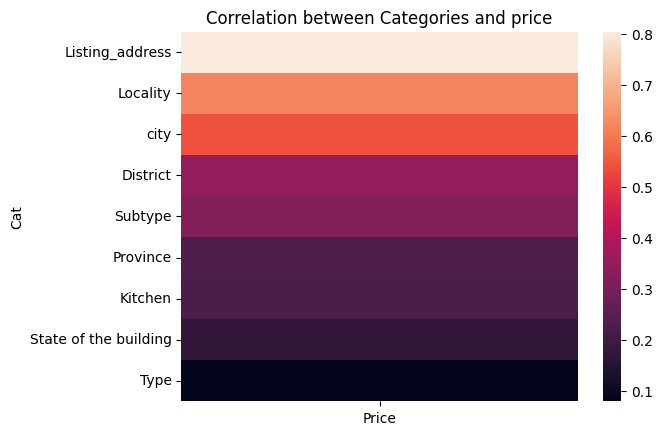

In [23]:
keys= []
values= []
for col in df_clean_outliers.select_dtypes(include='object').columns:
    #print(col)
    keys.append(col)
    values.append(s.correlation_ratio(df_clean_outliers[~df_clean_outliers[col].isnull()][col],df_clean_outliers[~df_clean_outliers[col].isnull()]["Price"]))
cat_corr =pd.DataFrame.from_records({"Cat": keys, "Price" : values}, index="Cat").sort_values(by="Price", ascending=False).iloc[1:,:]
display(cat_corr)
plot = sns.heatmap(data=cat_corr)
plot.set(title="Correlation between Categories and price")

Address, Locality and City seems to indicate a lot about price, but let's take a deeper look.

In [196]:
len(df_clean_outliers.index)/df_clean_outliers[["Listing_address", "Locality", "city"]].nunique()

Listing_address     1.479538
Locality            5.520666
city               11.327444
dtype: float64

So we have basically 1.4 Properties per address, 5.5 per locality but 11.4 per city. When we have one category to each dataset, then the correlation is high simply because there's a 1-1 relationship, but it does not tells us much. From all of those, City seems to be the most relevant, since even though it has a lot of properties inside each city, the correlation with price is still high. That would indicate that the variance in price is due, in part, on it being on that particular city. Locality as well, but I fear too many localities will have too small a sample to add meaningful information. Let's see.

,city,prop_city
city,,
1,0.478760,0.478760
2,0.142365,0.621125
3,0.076923,0.698048
4,0.049943,0.747991
5,0.035017,0.783008
...,...,...
109,0.000574,0.997130
123,0.000574,0.997704
161,0.001148,0.998852


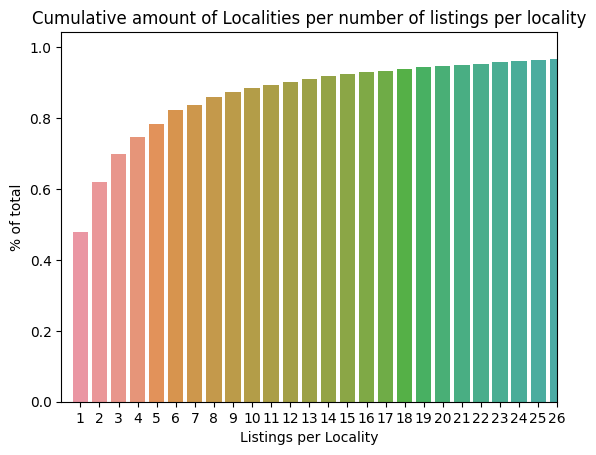

In [24]:
grouped = df_clean_outliers.groupby("Locality").agg({"city" : "count"}).groupby("city").agg({"city": "count"})
grouped = grouped/grouped.sum()
grouped["prop_city"] = grouped.cumsum()
plot = sns.barplot(data = grouped, x=grouped.index[0:50], y=grouped.prop_city[0:50])
plot.set(title="Cumulative amount of Localities per number of listings per locality", ylabel="% of total", xlabel="Listings per Locality")
plot.set_xlim(-1,25)
display(grouped)


Oh wow, Over 40% of our Localities have 1 home, over 60% has 1 or 2 and almost 70% has 3 or less. Let's see the same info for "city" 

,Locality,prop_city
Locality,,
1,0.166078,0.166078
2,0.114252,0.280330
3,0.087161,0.367491
4,0.075383,0.442874
5,0.050648,0.493522
...,...,...
145,0.001178,0.995289
163,0.001178,0.996466
203,0.001178,0.997644


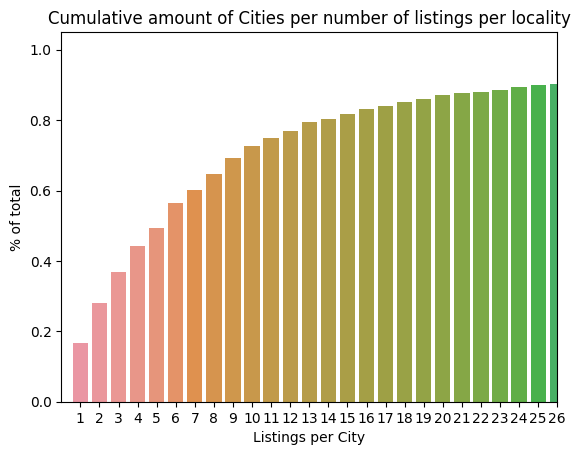

In [25]:
grouped = df_clean_outliers.groupby("city").agg({"Locality" : "count"}).groupby("Locality").agg({"Locality": "count"})
grouped = grouped/grouped.sum()
grouped["prop_city"] = grouped.cumsum()
plot = sns.barplot(data = grouped, x=grouped.index, y="prop_city")
plot.set(xlim=(-1,25), title="Cumulative amount of Cities per number of listings per locality", ylabel="% of total", xlabel="Listings per City")
display(grouped)

That is much better, over 60% of our cities has 3 or more listings.

Let's now look city by city and check the correlations between our variables inside each city.

,Bedroom,Living_area,Garden_area,Surface_of_land,Facade
Oostende,0.597982,0.613662,0.763805,0.411532,0.307924
Achêne,0.976905,0.946350,NaN,0.930490,0.421960
Mechelen,0.670009,0.768286,0.069262,0.476424,0.369571
Ixelles,0.482261,0.696670,0.721165,0.896089,0.252843
Leuven,0.819197,0.956027,-0.794291,0.577599,-0.076477
...,...,...,...,...,...
Ciply,0.872376,1.000000,NaN,-1.000000,-0.503667
Bastogne,0.053854,0.928977,NaN,NaN,-0.032184
Erps-Kwerps,0.680818,0.897572,NaN,0.806797,0.231941
Hondelange,0.774901,0.120170,NaN,-0.143519,0.331000


[Text(0.5, 1.0, 'Distribution of correlation between Price and numeric values within each city'),
 Text(0.5, 0, 'Correlation'),
 Text(0, 0.5, 'Density'),
 (-1.2, 1.2)]

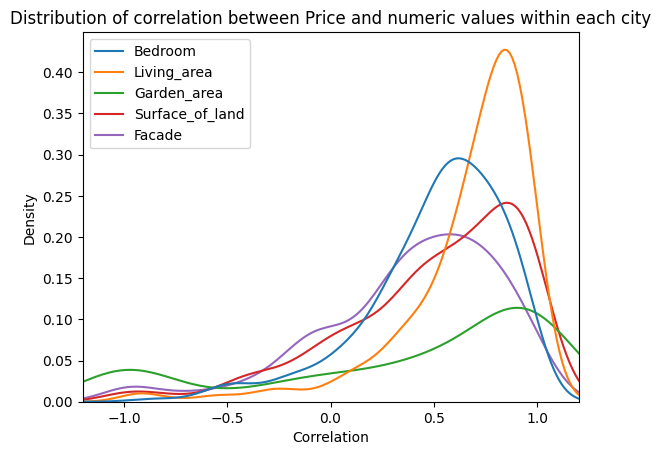

In [26]:
numeric_corr = []
for city in df_clean_outliers["city"].unique():
    df_by_city = df_clean_outliers[df_clean_outliers["city"] == city]
    if len(df_by_city.index) > 3:
        numeric_corr.append(df_by_city[["Bedroom", "Living_area", "Garden_area", "Surface_of_land", "Facade", "Price"]].corr()["Price"].to_frame(name=city))
corr_by_city = pd.concat(numeric_corr, axis=1).transpose()
corr_by_city = corr_by_city.iloc[:,:-1]
display(corr_by_city)
plot = sns.kdeplot(corr_by_city)
plot.set(title = "Distribution of correlation between Price and numeric values within each city"
        , xlabel="Correlation"
        , ylabel="Density"
        ,xlim=(-1.2,1.2)
        )


As we can see, living area continues to be one of the more strongly correlated numeric information we have with price. Let's take a look at the non-numeric categories.

,Type,Subtype,Kitchen,State of the building,Province
Oostende,0.207469,0.334934,0.306105,0.142251,NaN
Achêne,0.323037,0.933992,0.349375,0.390018,NaN
Mechelen,0.327045,0.500612,0.274296,0.394262,NaN
Ixelles,0.249880,0.361488,0.426470,0.277068,NaN
Leuven,0.664525,0.758394,0.503644,0.378276,NaN
...,...,...,...,...,...
Ciply,0.872376,1.000000,0.503667,NaN,NaN
Bastogne,0.025747,0.030701,0.005385,0.512885,NaN
Erps-Kwerps,NaN,0.928142,0.535863,0.538839,NaN
Hondelange,0.317695,0.317695,0.919513,0.919513,NaN


[Text(0.5, 1.0, 'Distribution of correlation between Price and categories within each city'),
 Text(0.5, 0, 'Correlation'),
 Text(0, 0.5, 'Density'),
 (-0.5, 1.2)]

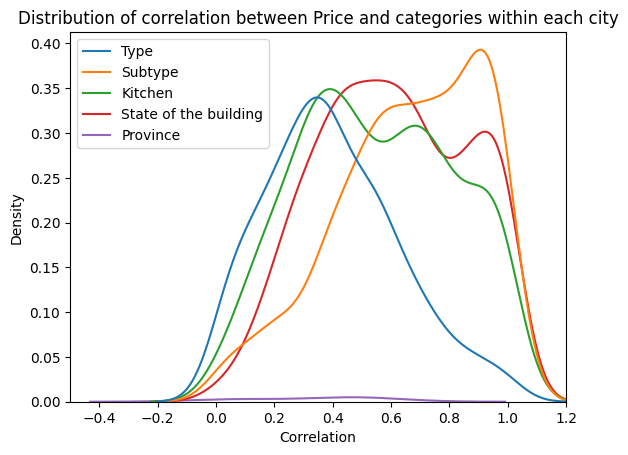

In [27]:
cat_corr = []

for city in df_clean_outliers["city"].unique():
    df_by_city = df_clean_outliers[df_clean_outliers["city"] == city].drop(["URL", "Locality", "District", "city", "Listing_address"] , axis=1)
    keys= []
    values= []
    if len(df_by_city.index) > 3:
        for col in df_by_city.select_dtypes(include='object').columns:
            keys.append(col)
            values.append(s.correlation_ratio(df_by_city[~df_by_city[col].isnull()][col],df_by_city[~df_by_city[col].isnull()]["Price"]))
        cat_corr.append(pd.Series(values, index=keys, name=city))
corr_by_city = pd.concat(cat_corr, axis=1).transpose()
display(corr_by_city)
plot = sns.kdeplot(corr_by_city)
plot.set(title = "Distribution of correlation between Price and categories within each city"
        , xlabel="Correlation"
        , ylabel="Density"
        ,xlim=(-0.5,1.2)
        )

As we can see, once we filter by city the correlation of the intangibles increase significantly, but still being less relevant than living area.

Surprisingly "Type" continues to not play a significant role compared to other variables llike Kitchen or SubType.

Now let's see if the price per m² varies between cities

[(0.0, 10000.0),
 Text(0.5, 1.0, 'Distribution of price per m²'),
 Text(0.5, 0, 'm² Price')]

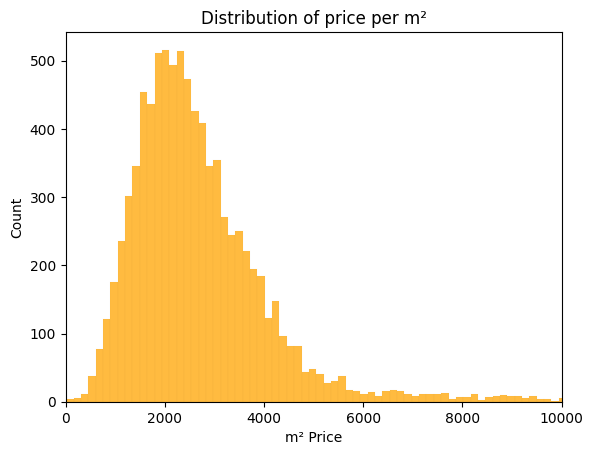

In [28]:
plot = sns.histplot(data=df_clean_outliers, x="Square_meter", color="orange")
plot.set(xlim=(0,10000)
        ,title="Distribution of price per m²"
        ,xlabel="m² Price"
        )